# Regression Classifier

This is our attempt to build a model to predict and understand average loan amount from specific country data and details about a project (which we extracted from the loan documents).

In [2]:
## Packages to import
from itertools import *
import numpy as np
import pandas as pd
import sys
## Install packages if need be
# !{sys.executable} -m pip install category_encoders
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install fancyimpute
# !{sys.executable} -m pip install xgboost

#Encoders and Imputers
from category_encoders import TargetEncoder, OneHotEncoder, HashingEncoder, BinaryEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

#Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

#Plotting and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# sklearn and models
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedKFold, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import preprocessing

First, the data needs to be loaded and relabeled for clear illustrations.

In [3]:
# ## Load Data
X = pd.read_csv('Finalized_Dataset.csv')
X.loc[X.Country == 'spain', 'Country'] = 'mexico' # Manually fix an incorrect value that was noticed
X.rename(columns={'0': 'Education/Social Prot', '1': 'Financial/Industry/Services/Energy',
                  '2': 'Public Admin/Communication', '3': 'Financial', '4': 'Industry/Communication',
                  '5': 'Agricultural/Conservation', '6': 'Energy/Transportation/Sanitation'}, inplace=True)

# Group dataset by Year and Country. This way, year and country only appears once.
X = X.groupby(['Year', 'Country']).agg({'Elec': 'mean', 'GDPpC': 'mean', 'Lit': 'mean', 'Gini': 'mean', 
                                    'Stability': 'mean', 'Education/Social Prot': 'mean',
                                    'Financial/Industry/Services/Energy': 'mean',
                                    'Public Admin/Communication': 'mean',
                                    'Financial': 'mean',
                                    'Industry/Communication': 'mean',
                                    'Agricultural/Conservation': 'mean',
                                    'Energy/Transportation/Sanitation': 'mean', 
                                    'loan_amount': 'mean'}).reset_index()

# X = X.groupby(['Year', 'Country']).agg({'Region': 'unique', 'Elec': 'mean', 'GDPpC': 'mean', 'Lit': 'mean', 'Gini': 'mean', 
#                                     'Stability': 'mean', 'Group 1': 'mean', 'Group 2': 'mean', 'Group 3': 'mean',
#                                     'Group 4': 'mean', 'Group 5': 'mean', 'Group 6': 'mean', 'Group 7': 'mean', 
#                                     'loan_amount': 'mean'}).reset_index()

# Put loans in millions of dollars
X.loan_amount = X.loan_amount.multiply(10**(-6))

# Remove outliers (idea dropped - no improvement in performance)
# X.drop(index=X.loc[(X.loan_amount > upper)].index, inplace=True)

## World Region was eventually dropped. It was showing no signs in improving model performance.
# X['Region'] = X.Region.apply(lambda x: ''.join([str(item) for item in x]))
# X = pd.get_dummies(X, columns=['Region'], drop_first=True)
y = X.loan_amount
X = X.drop(columns=['loan_amount', 'Year', 'Country'])

A quick sanity check on any imputed values to make sure they make sense.

In [4]:
X.loc[X.Elec <= 0, 'Elec'] = 0.001 # Electricity use shouldn't be negative
X.loc[X.GDPpC <= 0] = 1 # GDP per capita shouldn't be negative

Examine different forms of data to see if any improves model performance. Note: square roots, exponentials, etc were attempted. Anything leftover in current code seemed to positively affect model performance.

In [275]:
# X['GDPpC'] = np.log(X['GDPpC'])

# X['Elec'] = np.log(X['Elec'])

X['Gini'] = np.log(X['Gini'])

# X['Lit'] = np.log(X['Lit'])

Normalize data. In particular, stability needs normalized.

In [276]:
# X['GDPpC'] = (X['GDPpC'] - X['GDPpC'].mean()) / X['GDPpC'].std()

X['Stability'] = (X['Stability'] - X['Stability'].mean()) / X['Stability'].std()

In [5]:
# Useful function - might not be used
def train_test(X_train, X_test, y_train, y_test, classifier, ismultilabel=False):
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    
    print("Train score: {:.2f}".format(classifier.score(X_train, y_train)))
    print("Test score: {:.2f}\n".format(classifier.score(X_test, y_test)))
#     print("Classification report:\n{}".format(classification_report(y_test, pred, zero_division=0)))
    
#     if not ismultilabel:
#         print(confusion_matrix(y_test,pred))
    
    return classifier

Create train, test split

In [278]:
### Split train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)

Look for outliers - it did not affect model performance to remove outliers, so they were eventually kept

In [279]:
loan_mean, loan_std = np.mean(y_train), np.std(y_train)
cutoff = loan_std * 3
lower, upper = loan_mean - cutoff, loan_mean + cutoff

outliers = [x for x in y_train if x < lower or x > upper]

In [281]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

#### Linear Regression

First attempt a Linear Regression as it is easily explanable.

In [282]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [283]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [284]:
print('--5 FOLD CROSS VALIDATION SCORES--')
for i in scores:
    i = round(i,2)
    print(i)
print('\n')    
print('--CROSS VALIDATION MEAN--')
print(round(scores.mean(),2))

--5 FOLD CROSS VALIDATION SCORES--
-45186.66
-13833.77
-36937.73
-13855.46
-468083.34


--CROSS VALIDATION MEAN--
-115579.39


#### Random Forest

With such a high mean-CV, we would like to explore other models. Other group members expressed interest in SVMs, so here I chose to try a random forest:

In [239]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)

In [240]:
from sklearn import metrics
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

print('--5 FOLD CROSS VALIDATION SCORES--')
for i in scores:
    i = round(i,2)
    print(i)
print('\n')    
print('--CROSS VALIDATION MEAN--')
print(round(scores.mean(),2))

model.fit(X_train, y_train)

--5 FOLD CROSS VALIDATION SCORES--
-27001.94
-16181.86
-46293.29
-22502.21
-44546.9


--CROSS VALIDATION MEAN--
-31305.24


RandomForestRegressor(max_depth=6, n_estimators=10, random_state=0)

With this mean-CV being much lower, we look into visualizations to help understand what is affecting this model the most. At this point, the notebook was adjusted in normalizing data, converting values (square roots, logarithms, etc), removing outliers, to see their impact on model performance. However, only taking the logarithm of the gini coefficient improved performance.

#### Visualizations

A shap plot gives an idea of which features are impacting the model more. As can be seen from the figure below, sector, stability, and GDP per capita all significantly affect output magnitude.

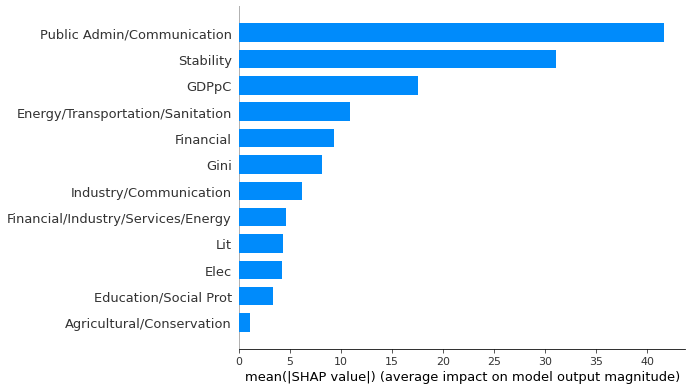

In [241]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Impact of variables

# Region does not seem to be an impact

# Other variables more important

A shap summary plot gives a more detailed view. Here, Public Administration / Communication is positively correlated with average loan amount. Stability is negative correlated. (This means a more negative stability increases the average loan amount prediction.) This is actually in agreement with plots done during data exploration.

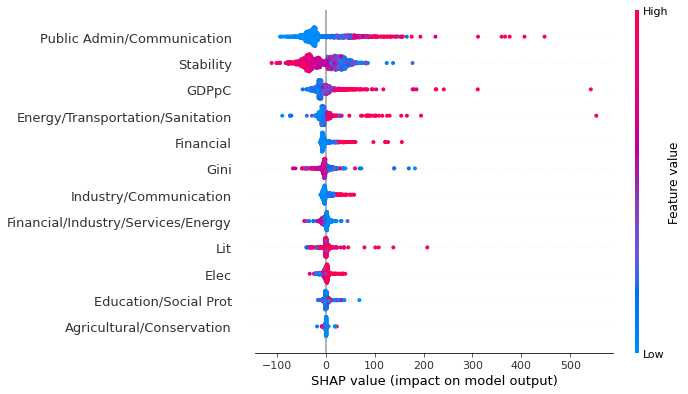

In [243]:
shap.summary_plot(shap_values, X_train)

# Group 3 positively correlated

# Stability negative correlated

We wish to see how each feature depends on other features.

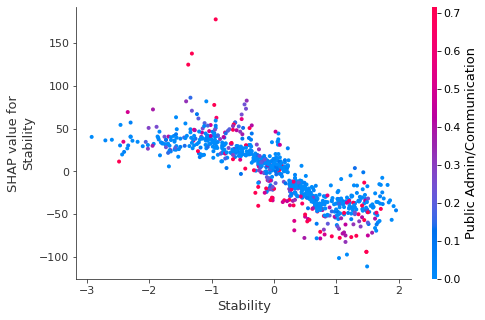

In [244]:
shap.dependence_plot('Stability', shap_values, X_train)

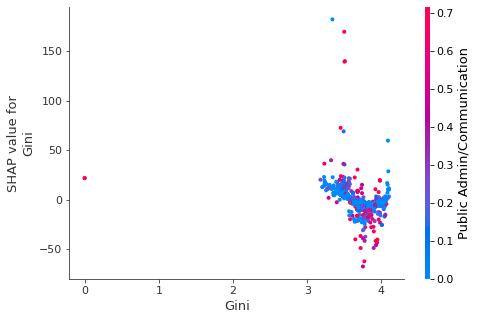

In [245]:
shap.dependence_plot('Gini', shap_values, X_train)

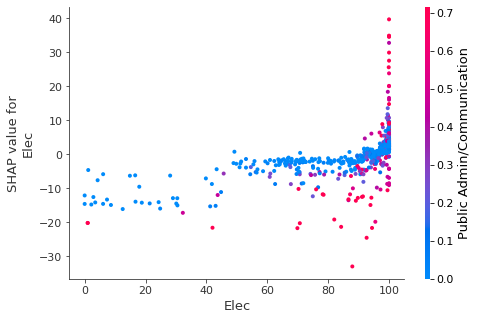

In [246]:
shap.dependence_plot('Elec', shap_values, X_train)

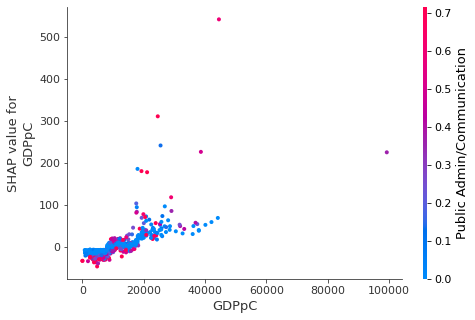

In [247]:
shap.dependence_plot('GDPpC', shap_values, X_train)

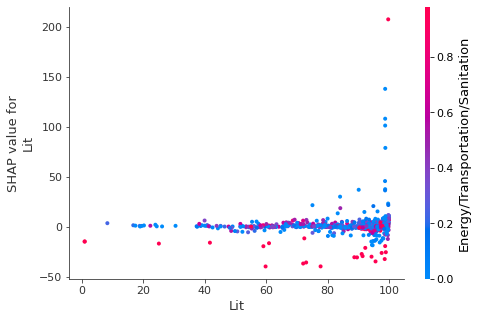

In [248]:
shap.dependence_plot('Lit', shap_values, X_train)

We create a plot to see specific examples on how our random forest model determines impact on its loan amount prediction.

In [251]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [252]:
shap_plot(0)

# 52.13 million

#### Verification and Accuracy

In [249]:
y_pred = model.predict(X_test)

In [250]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(y_pred,2)

# Randomly pick some observations
random_picks = np.arange(1,197,20) # Every 20 rows
S = X_output.iloc[random_picks]
S

,Elec,GDPpC,Lit,Gini,Stability,Education/Social Prot,Financial/Industry/Services/Energy,Public Admin/Communication,Financial,Industry/Communication,Agricultural/Conservation,Energy/Transportation/Sanitation,predict
428,100.000000,9401.231328,85.655055,3.723281,-0.611333,0.317877,0.000000,0.664802,0.0,0.014426,0.000000,0.000000,336.27
394,100.000000,7361.363679,98.981270,3.608212,-1.001368,0.000000,0.426426,0.000000,0.0,0.000000,0.231364,0.328660,106.52
129,100.000000,26732.575010,71.116536,3.626472,1.600231,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.966566,64.62
625,99.710000,16433.260160,82.451642,3.740048,-1.478875,0.032154,0.000000,0.000000,0.0,0.000000,0.000000,0.963834,157.40
537,96.749045,7960.725393,91.603229,3.970292,-0.565064,0.159357,0.584082,0.091969,0.0,0.006352,0.000000,0.154754,137.16
475,98.481575,13070.559490,76.502679,3.909620,-0.553497,0.076723,0.254890,0.000000,0.0,0.000000,0.000000,0.661114,116.45
538,80.157275,7262.258084,88.699341,3.918005,-0.646035,0.144383,0.250135,0.000000,0.0,0.000000,0.000000,0.601866,87.22
350,95.200000,6690.373751,91.866426,4.072440,-1.525144,0.143474,0.000000,0.000000,0.0,0.000000,0.850376,0.000000,85.08
520,96.315259,8037.886137,91.263666,3.956996,-0.657602,0.129513,0.222890,0.055004,0.0,0.000000,0.000000,0.591239,168.56
813,99.964226,9464.682256,98.537915,3.504355,-0.379989,0.000000,0.000000,0.797879,0.0,0.000000,0.000000,0.192166,370.81


Check out MSE:

In [253]:
y.mean()

134.7645079849968

#### Baseline Model

Our baseline model takes the total average loan amount in the training set as its prediction

In [254]:
y_baseline = y_train.mean()*np.ones(len(y_test))

In [255]:
np.sum((y_baseline - y_test)**2) / len(y_test)

27076.22980054776

#### Linear Regression Model

In [256]:
lr.fit(X_train,y_train)
np.sum((lr.predict(X_test) - y_test)**2) / len(y_test)

19627.827312200658

#### Random Forest Model

In [258]:
np.sum((y_pred - y_test)**2) / len(y_test)

14802.93781749602

Here, we can see random forest performed the best on the training set. The linear regression seems somewhat reasonable. However, of particular note with the mean-CV calculated earlier, the linear regression model sometimes has extremely high MSE. After running the model several more times, this happened more than once, so we feel more confident taking the random forest model approach especially considering the lower MSE value it has over the linear regression model.